In [1]:
import numpy as np
import matplotlib.pyplot as plt


#Activation functions

def sigmoid(Z):
    return 1 / (1 + np.exp(-np.clip(Z, -250, 250)))


def relu(Z):
    return np.maximum(0, Z)

def sigmoid_bk(Z):
    sig = sigmoid(Z)
    return sig * (1 - sig)

def relu_bk(Z):
    return np.where(Z <=0, 0, 1)

act_funcs = {'sigmoid':sigmoid, 'relu':relu}
back_act = {'sigmoid': sigmoid_bk, 'relu': relu_bk}

#Layer moduel
class Layer(object):
    def __init__(self, units, activation):
        self.units = units
        self.activation = act_funcs[activation]
        self.back_act = back_act[activation]
        self.a_h = None
        self.z_h = None
        self.W = None
        self.b = None

In [34]:
#Model moduel
class Model(object):
    def __init__(self, lr, epochs, batch_size=200, seed=123):
        self.arch = []
        self.lr = lr
        self.epochs = epochs
        self.rnd = np.random.RandomState(seed)
        self.batch_size = batch_size
        self.cost = []
        self.fit_flag = False
        
    def init_w(self):
        n_layers = len(self.arch)
        for i in range(1, n_layers):
            layer0 = self.arch[i-1]
            layer1 = self.arch[i]
            w_ = self.rnd.randn(layer0.units, layer1.units)
            b_ = np.zeros(layer1.units)
            layer1.W = w_
            layer1.b = b_
            
    def init_az(self):
        for layer in self.arch:
            layer.a_h = None
            layer.z_h = None
    
    def add(self, layer):
        self.arch.append(layer)
        
    def _compute_cost(self, y, output):
        term1 = -np.dot(y.T, np.log(output))
        term2 = np.dot((1- y).T, np.log(1 - output))
        cost = (term1 + term2)[0,0]
        dA_init = -(np.divide(y, output) - np.divide(1 - y, 1 - output))
        return cost, dA_init
        
    def _forward(self, layer0, layer1):
        a_h0 = layer0.a_h
        z_h1 = np.dot(a_h0, layer1.W) + layer1.b
        a_h1 = layer1.activation(z_h1)
        layer1.z_h = z_h1
        layer1.a_h = a_h1
        
    def _backward(self, layer0, layer1, dA):
        dW = np.dot(layer0.a_h.T, layer1.back_act(layer1.z_h) * dA)
        db = np.sum(layer1.back_act(layer1.z_h) * dA, axis=0, keepdims=True)
        dA = np.dot(layer1.back_act(layer1.z_h) * dA, layer1.W.T)
        layer1.W = layer1.W - self.lr * dW
        layer1.b = layer1.b - self.lr * db
        return dA

    def fit(self, X, y, retrain=True):
        #########################
        #init all Ws and set a_h0 = X
        #########################
        
        idx = [i for i in range(len(X))]
        self.rnd.shuffle(idx)
        idx = idx[:self.batch_size]
        n_layers = len(self.arch)
        self.init_w()
        if retrain:
            self.init_az()
        if X.shape[1] == self.arch[0].units:
            self.arch[0].a_h = X[idx]
        else:
            raise Exception("Input shape is not right")
        
        for e in range(self.epochs):
            #######################
            # forward propra
            #######################
            for i in range(1, n_layers):
                layer0 = self.arch[i - 1]
                layer1 = self.arch[i]
                self._forward(layer0, layer1)
                
            cost, dA_init = self._compute_cost(y[idx], self.arch[-1].a_h)
            self.cost.append(cost)
            dA = dA_init
            
            #######################
            # backward propra
            #######################
            for j in range(1, n_layers):
                layer0 = self.arch[-j - 1]
                layer1 = self.arch[-j]
                dA = self._backward(layer0, layer1, dA)
        
        self.fit_flag = True
        return self
    
    def predict(self, X):
        if self.fit_flag:
            n_layers = len(self.arch)
            for i in range(1, n_layers):
                layer = self.arch[i]
                Z = np.dot(X, layer.W) + layer.b
                X = layer.activation(Z)
            self.fit_flag = True
            return X
        else:
            print('The model has not been trained yet')

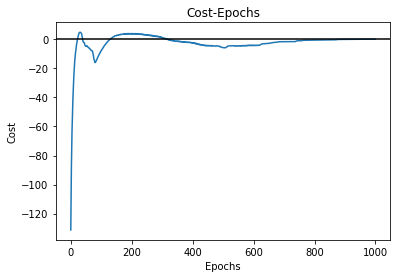

In [35]:
#Fit model, plot cost-epochs chart
from sklearn.datasets import make_moons


X, y = make_moons(n_samples=500, noise=0.1)
y = y.reshape(-1, 1)

model_nn = Model(lr=0.0001, epochs=1000)
model_nn.add(Layer(2, 'relu'))
model_nn.add(Layer(4, 'relu'))
model_nn.add(Layer(8, 'relu'))
model_nn.add(Layer(8, 'relu'))
model_nn.add(Layer(5, 'relu'))
model_nn.add(Layer(1, 'sigmoid'))


model_nn.fit(X, y)
cost = model_nn.cost
plt.plot(range(len(cost)), cost)
plt.axhline(color='k')
plt.title("Cost-Epochs")
plt.xlabel('Epochs')
plt.ylabel('Cost');

In [36]:
#Decsion boundary function
def plot_db(model_nn, ax):    
    ax.scatter(X[:,0], X[:, 1], c=y.ravel(), cmap='jet')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100),
                        np.linspace(ylim[0], ylim[1], 100))
    xy = np.c_[xx.ravel(), yy.ravel()]
    zz = np.where(model_nn.predict(xy) > 0.5, 1, 0).reshape(xx.shape)
    ax.contourf(xx, yy, zz, alpha=0.5, cmap='jet')

In [43]:
#Train a MLP from sklearn
from sklearn.neural_network import MLPClassifier


model2 = MLPClassifier(hidden_layer_sizes=((4, 4)), random_state=100, max_iter=1000)
model2.fit(X, y.ravel())

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(4, 4), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=100, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

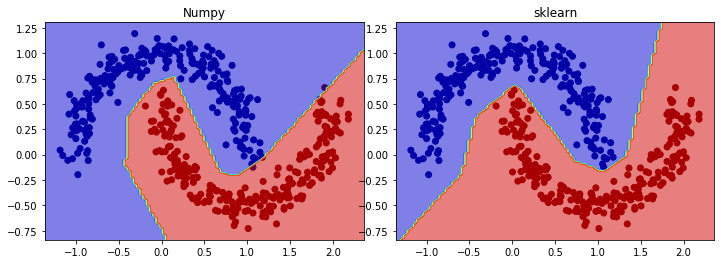

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={"wspace":0.1})
ax1 = axes[0]
ax2 = axes[1]
plot_db(model_nn, ax1)
plot_db(model2, ax2)
ax1.set_title('Numpy')
ax2.set_title('sklearn');
